In [26]:
# import

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import hog # for feature extraction
import time
import pickle
import itertools
import seaborn as sns

In [27]:
# path setting
base_path = r"D:\STAT542\midterm project"
model_save_path = os.path.join(base_path,"trained_model")
if not os.path.isdir(model_save_path):
    os.makedirs(model_save_path)

In [28]:
def data_loader(ip_path=r"D:\STAT542\midterm project\train",resize_shp=(64,64),dtype="train_val"): # read data & transform into required format
    
    loaded_data = []
    loaded_target = [] # if test set, no label
    for f in os.listdir(ip_path):
        img = cv2.imread(os.path.join(ip_path,f)) # read image
        mat = np.array(cv2.resize(img,resize_shp)) # reshape the read image
        loaded_data.append(mat) # transform the image into 1-d array
        if dtype == "train_val":
            loaded_target.append(f.split(".")[0])
        elif dtype == "test":
            continue
    return loaded_data,loaded_target

def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### load data

In [29]:
all_data,all_target = data_loader(ip_path=r"D:\STAT542\midterm project\train",resize_shp=(64,64),dtype="train_val")

In [30]:
print("whole dataset size:",len(all_data)) # not evenly distributed (doesn't live up to 7:2:1); can do cross validation

whole dataset size: 25000


### cross-validation for deciding best hyperparameters

In [10]:
# use 20% of data for model testing, 80% of data for cross validation & model training

test_idx = list(range(0,len(all_data),5))
train_val_idx = [i for i in list(range(0,len(all_data))) if i not in test_idx] # try with part of the total dataset
print("train set size",len(train_val_idx),"test set size:",len(test_idx))

train set size 20000 test set size: 5000


In [8]:
# extract feature
X_train_val = []

start_time = time.time()
for i in range(len(all_data)):
    
    if i in train_val_idx: # only select part of the dataset
    
        feature,hog_img = hog(all_data[i],orientations=9,pixels_per_cell=(8,8),cells_per_block=(2,2),visualize=True,multichannel=True)
        # check if the parameters here needs to be unified
        X_train_val.append(feature) # no need to further scale the feature?

X_train_val = np.array(X_train_val) # transform into numpy array
print(X_train_val.shape)
print("time spent: %.2f s"%(time.time()-start_time))

(20000, 1764)
time spent: 195.30 s


In [9]:
# transform target
Y_train_val = [1 if i=="cat" else 0 for i in all_target]
Y_train_val = np.array(Y_train_val)
Y_train_val = Y_train_val.reshape(len(Y_train_val),1)

Y_train_val = Y_train_val[train_val_idx] # only select part of the dataset
print(Y_train_val.shape)

(20000, 1)


In [33]:
# define parameter space & fold number
param_grid = {"C": np.logspace(-2,2,2-(-2)+1),"gamma": np.logspace(-2,2,2-(-2)+1),"kernel": ["linear","rbf","poly"]}
n_fold = 5 # reduce the fold number

# create a StratifiedKFold object
stratified_kf = StratifiedKFold(n_splits=n_fold,shuffle=True,random_state=16) # currently use all cpu cores

start_time = time.time()

# grid search of the optimal parameter
grid_search = GridSearchCV(SVC(),param_grid,cv=stratified_kf,n_jobs=-1,scoring='accuracy',return_train_score=True)
grid_search.fit(X_train_val,Y_train_val.ravel())

# print the best parameter combination
print("best parameter combination:", grid_search.best_params_)
print("best testing score:",grid_search.best_score_)
print("time spent: %s s"%(time.time()-start_time))

best parameter combination: {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
best testing score: 0.7738000000000002
time spent: 19377.858439445496 s


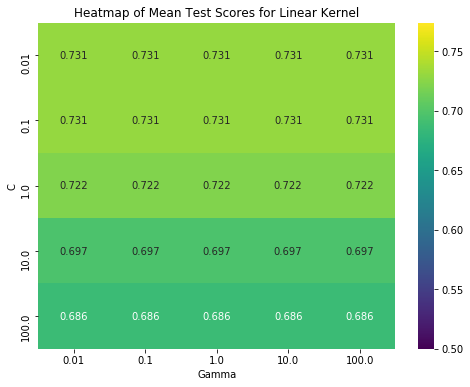

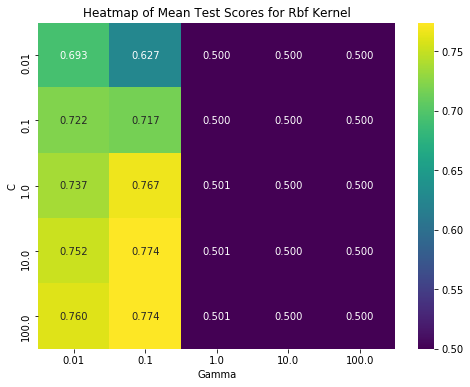

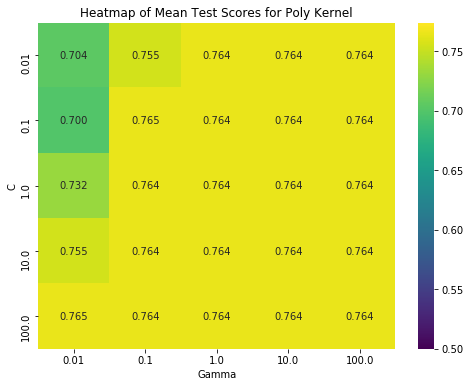

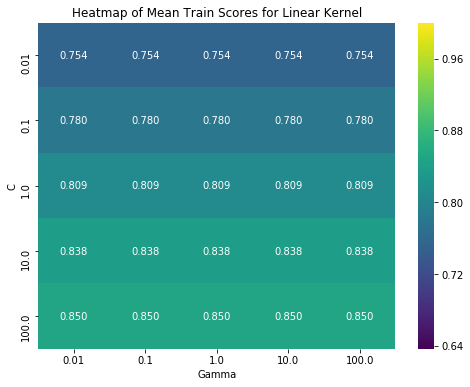

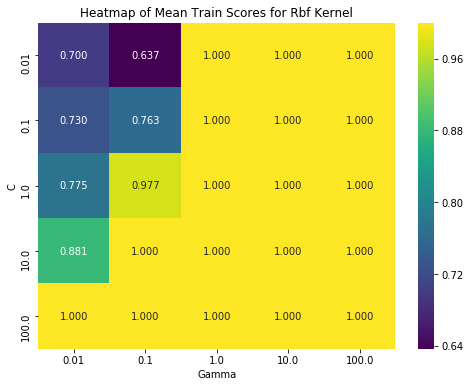

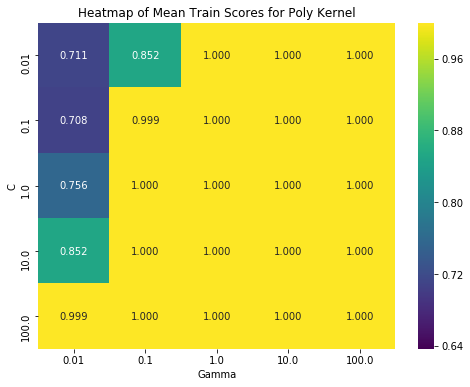

In [34]:
# visulize best parameters
cv_results = pd.DataFrame(grid_search.cv_results_)

# one heatmap for each kernel type
# unify colorbar range
test_min,test_max = cv_results["mean_test_score"].min(),cv_results["mean_test_score"].max() # actually the range is the same for train data

for kern in param_grid["kernel"]:
    
    tmp_cv_results = cv_results[cv_results["param_kernel"]==kern]

    # generate heatmap matrix & visualization
    # test result
    tmp_scores_matrix = tmp_cv_results.pivot_table(index="param_C",columns="param_gamma",values="mean_test_score")
    plt.figure(figsize=(8,6))
    sns.heatmap(tmp_scores_matrix,annot=True,fmt=".3f",cmap="viridis",vmin=test_min,vmax=test_max)
    plt.title(f"Heatmap of Mean Test Scores for {kern.capitalize()} Kernel")
    plt.xlabel("Gamma")
    plt.ylabel("C")
    plt.show()

train_min,train_max = cv_results["mean_train_score"].min(),cv_results["mean_train_score"].max()

for kern in param_grid["kernel"]:
    
    tmp_cv_results = cv_results[cv_results["param_kernel"]==kern]
    
    # train result
    tmp_scores_matrix = tmp_cv_results.pivot_table(index="param_C",columns="param_gamma",values="mean_train_score")
    plt.figure(figsize=(8,6))
    sns.heatmap(tmp_scores_matrix,annot=True,fmt=".3f",cmap="viridis",vmin=train_min,vmax=train_max)
    plt.title(f"Heatmap of Mean Train Scores for {kern.capitalize()} Kernel")
    plt.xlabel("Gamma")
    plt.ylabel("C")
    plt.show()

### train model & train result visulization

time spent: 1881.1927154064178 s
training accuracy: 1.0
classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

confusion matrix:


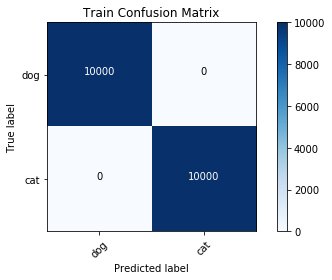

In [10]:
# retrain the model using the whole dataset & the selected best parameters

# initiate a new model
#best_model = SVC(**grid_search.best_params_)
best_model = SVC(**{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'})
start_time = time.time()
best_model.fit(X_train_val,Y_train_val.ravel()) # this doesn't support parallel running

# print the final training result
print("time spent: %s s"%(time.time()-start_time))

# results
Y_train_val_pred = best_model.predict(X_train_val)

# basic metrics
# prediction accuracy
print("training accuracy:",accuracy_score(Y_train_val_pred,Y_train_val.ravel()))

# classification report
print("classification report:")
print(classification_report(Y_train_val_pred,Y_train_val.ravel()))

# visulize the confusion matrix
print("confusion matrix:")
cm_train = confusion_matrix(Y_train_val_pred,Y_train_val.ravel())
plot_confusion_matrix(cm_train,title="Train Confusion Matrix",classes=["dog","cat"]) # make sure the order is correct (0-dog,1-cat)
plt.show()

In [11]:
# save the trained model
with open(os.path.join(model_save_path,'svm_model.pkl'),'wb') as model_file:
    pickle.dump(best_model,model_file)

### test model & test result visualization

In [12]:
# reload the model for performance test
with open(os.path.join(model_save_path,'svm_model.pkl'),'rb') as model_file:
    best_model = pickle.load(model_file)

In [13]:
# select data for prediction
# 1. avoid overlap with train_val_data 2. same number of cat & dog samples

# extract feature
X_test = []

start_time = time.time()
for i in range(len(all_data)):
    
    if i in test_idx: # only select part of the dataset
    
        feature,hog_img = hog(all_data[i],orientations=9,pixels_per_cell=(8,8),cells_per_block=(2,2),visualize=True,multichannel=True)
        # check if the parameters here needs to be unified
        X_test.append(feature) # no need to further scale the feature?

X_test = np.array(X_test) # transform into numpy array
print(X_test.shape)
print("time spent: %.2f s"%(time.time()-start_time))

# transform target
Y_test = [1 if i=="cat" else 0 for i in all_target]
Y_test = np.array(Y_test)
Y_test = Y_test.reshape(len(Y_test),1)

Y_test = Y_test[test_idx] # only select part of the dataset
print(Y_test.shape)

(5000, 1764)
time spent: 48.64 s
(5000, 1)


testing accuracy: 0.7972
classification report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.80      2470
           1       0.80      0.79      0.80      2530

    accuracy                           0.80      5000
   macro avg       0.80      0.80      0.80      5000
weighted avg       0.80      0.80      0.80      5000

confusion matrix:


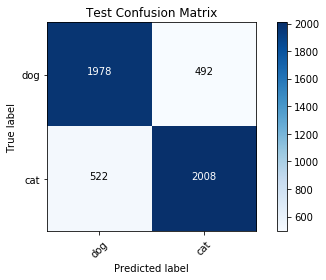

In [14]:
# results
Y_test_pred = best_model.predict(X_test)

# basic metrics
# prediction accuracy
print("testing accuracy:",accuracy_score(Y_test_pred,Y_test.ravel()))

# classification report
print("classification report:")
print(classification_report(Y_test_pred,Y_test.ravel()))

# visulize the confusion matrix
print("confusion matrix:")
cm_train = confusion_matrix(Y_test_pred,Y_test.ravel())
plot_confusion_matrix(cm_train,title="Test Confusion Matrix",classes=["dog","cat"]) # make sure the order is correct (0-dog,1-cat)
plt.show()